# Homework 5 - Loan Safety with Dec

###Coding Portion should be submitted on EdStem, and the Concept Portion on Gradescope.

The LendingClub is a peer-to-peer lending company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to default. In this assignment, you will practice:

* Use Pandas Dataframes to do feature engineering
* Train a decision tree model to predict the sentiment of product reviews.
* Visualize the decision tree
* Predict the probability of a certain label using the tree
* Investigate how the complexity of the tree affects the results

Fill in the cells provided marked `TODO` with code to answer the questions. **Unless otherwise noted, every answer you submit should have code that clearly shows the answer in the output.** Answers submitted that do not have associated code that shows the answer may not be accepted for credit. 

**Make sure to restart the kernel and run all cells** (especially before turning it in) to make sure your code runs correctly. 

> Copyright ©2021 Emily Fox, Hunter Schafer, and Valentina Staneva  All rights reserved.  Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Autumn Quarter 2020 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these course materials should contact the author.

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
sns.set()

# Investigate Data
In this first part of the assignment, we will investigate the data to get a better sense of what we are working with. 

> Remember that you should look through and understand the parts of the code that load in data since the later parts will assume you are familiar with the preprocessing we did.

First we load in the dataset and then inspect the values:

In [2]:
loans = pd.read_csv('lending-club-data.csv')
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,not_compliant,status,inactive_loans,bad_loans,emp_length_num,grade_num,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,762032,962526,4000,4000,4000,36 months,10.59,130.18,B,B2,Suture Express,1 year,RENT,50000,Not Verified,20110601T000000,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,JKM debt equalizer,641xx,MO,1.80,0,20000601T000000,2,46.0,NaN,9,0,5009,20.1,16,f,0.0,0.0,4340.76,4340.76,4000.0,340.76,0.0,0.0,0.0,20120501T000000,3042.76,NaN,20150201T000000,0,NaN,1,0,Fully Paid,1,0,2,5,0.4,1,1,1,0,3.12432,20140601T000000,0,1,1
1,815326,1022979,12000,12000,12000,60 months,19.69,315.87,E,E5,"John A. Penney Co./Viscom Systems, Inc.",10+ years,MORTGAGE,140000,Not Verified,20110701T000000,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 07/15/11 > Hello. I am an...,medical,Medical,017xx,MA,11.73,0,19980101T000000,3,24.0,NaN,6,0,10832,89.5,36,f,0.0,0.0,16237.30,16237.30,12000.0,4237.28,0.0,0.0,0.0,20130901T000000,8693.29,NaN,20130901T000000,0,NaN,1,0,Fully Paid,1,0,11,2,1.0,1,1,1,0,2.70746,20160701T000000,0,1,1
2,563689,725339,8000,8000,7875,36 months,7.51,248.89,A,A4,US Marines,10+ years,MORTGAGE,115000,Not Verified,20100801T000000,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,other,Water Heater,299xx,SC,8.94,0,19940201T000000,0,30.0,NaN,6,0,5301,14.1,24,f,0.0,0.0,8364.99,8234.29,8000.0,364.99,0.0,0.0,0.0,20110501T000000,6631.79,NaN,20110401T000000,0,NaN,1,0,Fully Paid,1,0,11,6,0.8,1,1,1,0,2.59711,20130801T000000,0,1,1
3,756260,949279,4000,4000,3975,60 months,13.99,93.06,C,C3,Child Care Careers,2 years,RENT,21996,Source Verified,20110501T000000,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 05/07/11 > N/a<br/> Borrower...,other,personal,920xx,CA,0.55,0,20070201T000000,1,NaN,NaN,3,0,448,17.2,6,f,0.0,0.0,4927.70,4896.91,4000.0,927.70,0.0,0.0,0.0,20130401T000000,2885.86,NaN,20130401T000000,0,NaN,1,0,Fully Paid,1,0,3,4,0.6,1,1,1,0,5.07692,20160501T000000,1,1,1
4,787083,990585,5400,5400,5400,36 months,15.23,187.81,C,C5,caliber collision center,2 years,RENT,18000,Verified,20110601T000000,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,debt,925xx,CA,15.47,0,20080201T000000,1,NaN,NaN,5,0,735,25.3,6,f,0.0,0.0,6673.33,6673.33,5400.0,1273.33,0.0,0.0,0.0,20131101T000000,1625.78,NaN,20150201T000000,0,NaN,1,0,Fully Paid,1,0,3,4,1.0,1,1,1,0,12.52070,20140601T000000,1,1,1


One of the features we will use in this assignment is the "grade" of the loan. We can investigate what this feature, "grade", looks like:

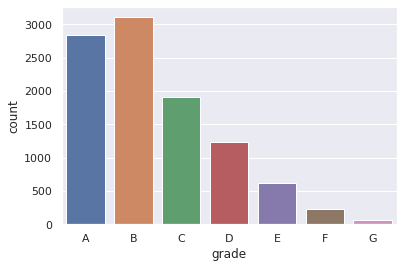

In [3]:
# Want the grades to show up in order from high to low
grade_order = sorted(loans['grade'].unique())

sns.countplot(x='grade', data=loans, order=grade_order)

We can see that over half of the loan grades are assigned values A or B. Each loan is assigned one of these grades, along with a more finely discretized feature called subgrade (feel free to explore that feature column as well!). These values depend on the loan application and credit report, and determine the interest rate of the loan. More information if you're interested can be found [here](https://www.lendingclub.com/investing/investor-education/interest-rates-and-fees).

Now let's look at another feature that will be used, "home ownership". This feature describes whether the loanee is mortaging, renting, or owns a home. We can see that a small percentage of the loanees own a home.

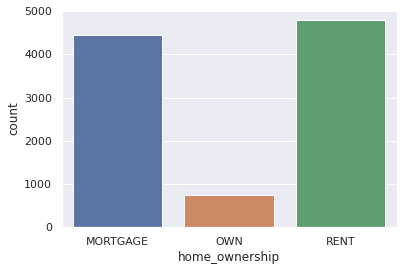

In [4]:
ownership_order = sorted(loans['home_ownership'].unique())

sns.countplot(x='home_ownership', data=loans, order=ownership_order)

## Investigate Data - Target
The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column 1 means a risky (bad) loan 0 means a safe loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:

* +1 as a safe loan,
* -1 as a risky (bad) loan.

We put this in a new column called `safe_loans`. This column will be the target values you will use while training.

In [5]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)

# Drop the old bad_loans column
loans = loans.drop(columns='bad_loans')

Now, let's explore the distribution of values for `safe_loans`. This gives us a sense of how many safe and risky loans are present in the dataset. 

In [6]:
only_safe = loans[loans['safe_loans'] == 1]
only_bad = loans[loans['safe_loans'] == -1]

print(f'Number safe  loans: {len(only_safe)} ({len(only_safe) * 100.0 / len(loans):.2f}%)')
print(f'Number risky loans: {len(only_bad)} ({len(only_bad) * 100.0 / len(loans):.2f}%)')

Number safe  loans: 8461 (84.61%)
Number risky loans: 1539 (15.39%)


## Investigate Data - Questions

### **🔍 Q1) Most frequent grade**
Write code to compute the most frequent value in the `'grade'` column of our dataset.  Store the grade as a `str` in the variable `mode_grade`. You may assume that there is no tie in the most frequent grade.

**Like all other problems, unless otherwise specified you need to write code to compute this value in the data rather than hard-coding the answer your find by some other means (e.g., looking at the plot above)**

In [11]:
### edTest(test_q1_most_common_loan_grade) ###

# TODO write code to find most frequent grade
mode_grade = loans['grade'].value_counts().idxmax()
mode_grade

'B'

### **🔍 Q2) Percentage Rent**
What percent of the loans in our dataset are for renting? Write code to compute this number as a value between 0 and 1, and store it in a variable named `percent_rent`.

In [12]:
### edTest(test_q2_percent_rent) ###

# TODO Write code to find percent of loans for rent
num_loan = len(loans[loans['home_ownership'] == 'RENT'])
percent_rent = num_loan / len(loans)
percent_rent

0.4791

---

# Preprocess Data for Learning
In this section, we pre-process the data to make it suitable for ML.

## Encode Categorical Features
We will be using both numeric and categorical features to predict if a loan is safe or risky. The features are described in code commments in the next cell. 

In [13]:
features = [
    'grade',                     # grade of the loan (e.g. A or B)
    'sub_grade',                 # sub-grade of the loan (e.g. A1, A2, B1)
    'short_emp',                 # one year or less of employment (0 or 1)
    'emp_length_num',            # number of years of employment (a number)
    'home_ownership',            # home_ownership status (one of own, mortgage, rent or other)
    'dti',                       # debt to income ratio (a number)
    'purpose',                   # the purpose of the loan (one of many values)
    'term',                      # the term of the loan (36 months or 60 months)
    'last_delinq_none',          # has borrower had a delinquincy (0 or 1)
    'last_major_derog_none',     # has borrower had 90 day or worse rating (0 or 1)
    'revol_util',                # percent of available credit being used (number between 0 and 100)
    'total_rec_late_fee',        # total late fees received to day (a number)
]

target = 'safe_loans'                   # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]
loans.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
0,B,B2,0,2,RENT,1.80,debt_consolidation,36 months,0,1,20.1,0.0,1
1,E,E5,0,11,MORTGAGE,11.73,medical,60 months,0,1,89.5,0.0,1
2,A,A4,0,11,MORTGAGE,8.94,other,36 months,0,1,14.1,0.0,1
3,C,C3,0,3,RENT,0.55,other,60 months,1,1,17.2,0.0,1
4,C,C5,0,3,RENT,15.47,debt_consolidation,36 months,1,1,25.3,0.0,1


In [14]:
loans.columns

Index(['grade', 'sub_grade', 'short_emp', 'emp_length_num', 'home_ownership',
       'dti', 'purpose', 'term', 'last_delinq_none', 'last_major_derog_none',
       'revol_util', 'total_rec_late_fee', 'safe_loans'],
      dtype='object')

With how `sklearn` implemented its `DecisionTreeClassifier`, it is only able to handle numerical features; the technical reason being it only allows binary splits and assumes (like other `sklearn` models), that the data is only numerical. This means we need to translate the categorical features into numeric ones. 

The easiest way to do this is a **one-hot encoding** of each categorical feature. A one hot encoding of a feature creates new, derived, features that take on the value 0 or 1 (one new feature for each possible value of the original). This allows us to turn a categorical feature into a series of binary (0 or 1) numerical features.

For examples, if we had the dataset shown below where 'Gender' takes on values 'M' (Male), 'F' (Female), 'O' (Other) and 'HasHouse' takes on values 'Y' (Yes), and 'N' (No). This dataset would not work by default in scikit-learn since it has features with categorical values.

| Gender | HasHouse | Age |
|--------|----------|-----|
| M      | N        | 19  |
| F      | Y        | 23  |
| O      | Y        | 24  |
| F      | N        | 21  |

To fix this, we could use a one-hot encoding to transform the categorical features into numeric ones. A one-hot encoding of the categorical features would be 

| Gender_M | Gender_F | Gender_O | HasHouse_N | HasHouse_Y | Age |
|----------|----------|----------|------------|------------|-----|
| 1        | 0        | 0        | 1          | 0          | 19  |
| 0        | 1        | 0        | 0          | 1          | 23  |
| 0        | 0        | 1        | 0          | 1          | 24  |
| 0        | 1        | 0        | 1          | 0          | 21  |

Note that the original 'Gender' column has been transformed into three related columns 'Gender_M', 'Gender_F', and 'Gender_O' which contains zeros or ones depending on the rows' original value. For each row, only one of these derived columns will contain a one (hence the name one-hot encoding).

To do this in `pandas`, we use the `get_dummies()` method (another name for one-hot encoding, is dummy variable). We show the new features of the data after running the function in the next cell.

In [15]:
loans = pd.get_dummies(loans)
features = list(loans.columns)
features.remove('safe_loans')
features

['short_emp',
 'emp_length_num',
 'dti',
 'last_delinq_none',
 'last_major_derog_none',
 'revol_util',
 'total_rec_late_fee',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'sub_grade_A1',
 'sub_grade_A2',
 'sub_grade_A3',
 'sub_grade_A4',
 'sub_grade_A5',
 'sub_grade_B1',
 'sub_grade_B2',
 'sub_grade_B3',
 'sub_grade_B4',
 'sub_grade_B5',
 'sub_grade_C1',
 'sub_grade_C2',
 'sub_grade_C3',
 'sub_grade_C4',
 'sub_grade_C5',
 'sub_grade_D1',
 'sub_grade_D2',
 'sub_grade_D3',
 'sub_grade_D4',
 'sub_grade_D5',
 'sub_grade_E1',
 'sub_grade_E2',
 'sub_grade_E3',
 'sub_grade_E4',
 'sub_grade_E5',
 'sub_grade_F1',
 'sub_grade_F2',
 'sub_grade_F3',
 'sub_grade_F4',
 'sub_grade_F5',
 'sub_grade_G1',
 'sub_grade_G2',
 'sub_grade_G3',
 'sub_grade_G4',
 'sub_grade_G5',
 'home_ownership_MORTGAGE',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'purpose_car',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_home_improvement',
 'purpose_house',
 '

Here is a preview of the new dataset. Notice our categorical features have become 0/1s represented over many columns (e.g. "grade" becamse "grade_A" through "grade_F").

In [16]:
loans.head()

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months
0,0,2,1.80,0,1,20.1,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,0,11,11.73,0,1,89.5,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0,11,8.94,0,1,14.1,0.0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0,3,0.55,1,1,17.2,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,0,3,15.47,1,1,25.3,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0


---
# Model Training
In this section, you will start writing code to train the decision tree model. 

First we split the data into 80% training data and 20% validation data. For this assignment, we will not use a test set since we aren't going to be deploying this model in the future and don't need to make a claim on our accuracy guarantee. 

In [17]:
from sklearn.model_selection import train_test_split

train_data, validation_data = train_test_split(loans, test_size=0.2, random_state=5)

## **🔍 Q3) Train first classifier**

Now let's use `sklearn`'s `DecisionTreeClassifier` (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)) 
to create a loan-safety prediction model on the training data. 

Train a decision tree classifier for this data. When creating the model you should only pass in the values `max_depth=6` and `random_state=6` (to make sure we get the same values). Use the features and target defined earlier when training the model on the training data. Save the tree in a variable called `decision_tree_model`.

In [18]:
### edTest(test_q3_decision_tree_model) ###

from sklearn.tree import DecisionTreeClassifier

# TODO train a model with max_depth=6
decision_tree_model = DecisionTreeClassifier(max_depth = 6, random_state = 6).fit(train_data[features], train_data[target])

Next, we want you to visualize what the tree looks like. In the cell below, we have defined a function to visualize the tree. 

Visualizing a depth 7 tree can be hard, so instead we will train another model stored in a variable called `small_tree_model` that has `max_depth=2`.

Installing Graphviz (especially on Windows) can be kind of tricky. If the code below doesn't run correctly, we provide an image to the picture you should have seen! 

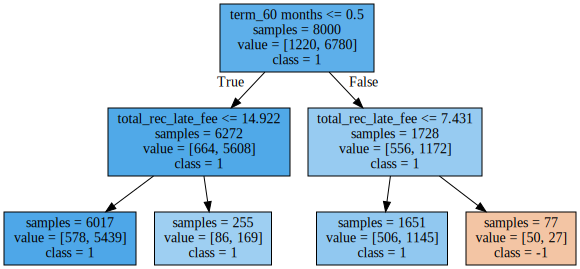

In [19]:
import graphviz
from sklearn import tree


def draw_tree(tree_model, features):
    """
    visualizes a Decision Tree
    """
    tree_data = tree.export_graphviz(tree_model, 
                                    impurity=False, 
                                    feature_names=features,
                                    class_names=tree_model.classes_.astype(str),
                                    filled=True,
                                    out_file=None)
    graph = graphviz.Source(tree_data) 
    display(graph)
    
small_tree_model = DecisionTreeClassifier(max_depth=2, random_state=6)
small_tree_model.fit(train_data[features], train_data[target])
draw_tree(small_tree_model, features)

Each node in the tree shows
* If it's an internal node, show what feature and value it splits on
* `samples`: The number of samples at that node
* `value`: The counts for each label at that node
* `class`: The majority class at that node
* The color showing how confident it is in the predictions at that node (blue is class +1, orange is class -1, white is in between). This corresponds to the probability of it predicting a certain label.

## Making Predictions
Now that we have trained the model, let's look at how it makes predictions on our data.

### **🔍 Q4) Accuracies**
Compute the training accuracy and validation accuracy using both your `decision_tree_model`. Calculate which percentage of those examples it classified correctly as a number between 0 and 1. So for this problem, you will need to make two variables:
* `decision_train_accuracy` for `decision_tree_model`'s training accuracy
* `decision_validation_accuracy` for `decision_tree_model`'s validation accuracy

In [20]:
### edTest(test_q4_validation_accuracy) ###

#TODO Find validation accuracy
from sklearn.metrics import accuracy_score

decision_train_accuracy = accuracy_score(train_data[target], decision_tree_model.predict(train_data[features]))
decision_validation_accuracy = accuracy_score(validation_data[target], decision_tree_model.predict(validation_data[features]))

print(decision_train_accuracy)
print(decision_validation_accuracy)

0.859375
0.8355


### **🔍 Q5) Tall Tree**
Next, you should train another decision tree model with `max_depth=10` (remember to also pass in `random_state=6`!). This will make a much deeper tree. 

In the cell below, train the model on the training data and report its training and validation accuracy. Save the model in a variable called `big_tree_model`, the training accuracy in a variable called `big_train_accuracy` and validation accuracy `big_validation_accuracy`.

Look back at the values in the last question to see if your values here make sense with what you know about heights of trees.

In [23]:
### edTest(test_q5_big_tree) ###

# TODO train a model with max_depth=10
big_tree_model = DecisionTreeClassifier(max_depth = 10, random_state = 6).fit(train_data[features], train_data[target])

big_train_accuracy = accuracy_score(train_data[target], big_tree_model.predict(train_data[features]))
big_validation_accuracy = accuracy_score(validation_data[target], big_tree_model.predict(validation_data[features]))

print(big_train_accuracy)
print(big_validation_accuracy)

0.884125
0.826


---
# **Q6) 🔍 Finding Right Fit**
As we saw in the previous example, if we aren't careful with how we set `max_depth`, our model can potentially overfit or underfit. 

A common way of limiting the depth of the tree is to consider two early stopping rules:
* When when the tree reaches a maximum depth (`max_depth`)
* When the leaf nodes have too few data samples in them (`min_samples_leaf`)

Instead of writing the standard hyper-parameter tuning loop you've written before (i.e. loop over possible choices of something like $\lambda$, train on the training data with that value of $\lambda$, and validate using a validation set), we will use a `sklearn` module that does this for us using k-fold cross validation.

The reason we want to use a library for this task is it gets more complicated when we want to find the best combination of both `max_depth` and `min_samples_leaf`. The code becomes quite tedious to write since your loop would need to try all pairs of values for `max_depth` and `min_samples_leaf` and have some way of storing the results to compare.

Instead, we use use `sklearn`'s `GridSearchCV` (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)) to do all this book-keeping for us! You should look at the documentation on that page (there is a good example underneath the method reference) to solve the following step.

Use `GridSearchCV` to try all combinations of 
* `min_samples_leaf`: [1, 10, 50, 100, 200, 300]
* `max_depth`: [1, 5, 10, 15, 20]

Some implementation details:
* For our code later, save the `GridSearchCV` object in a variable called `search` and the dictionary specifying parameters in a variable called `hyperparameters`.
* You should use 6-fold valudation `cv=6` and make sure it records the training accuracies by using `return_train_score=True`.
* Print the result using the `best_params_` property on the `GridSearchCV` object. 
* This might take some time to run! 

In [24]:
### edTest(test_q6_grid_search) ###

# TODO Use GridSearchCV to find best settings of hyperparameters
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    "max_depth" : [1, 5, 10, 15, 20],
    "min_samples_leaf" : [1, 10, 50, 100, 200, 300],
}

search = GridSearchCV(DecisionTreeClassifier(), hyperparameters, cv=6, return_train_score=True).fit(train_data[features], train_data[target])
print("Best parameter combination is", search.best_params_)


Best parameter combination is {'max_depth': 5, 'min_samples_leaf': 50}


We can also plot the train and validation accuracy of the models for different settings of the hyper-parameters. The plot will be in 3D since there are 2 inputs for each model specification.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


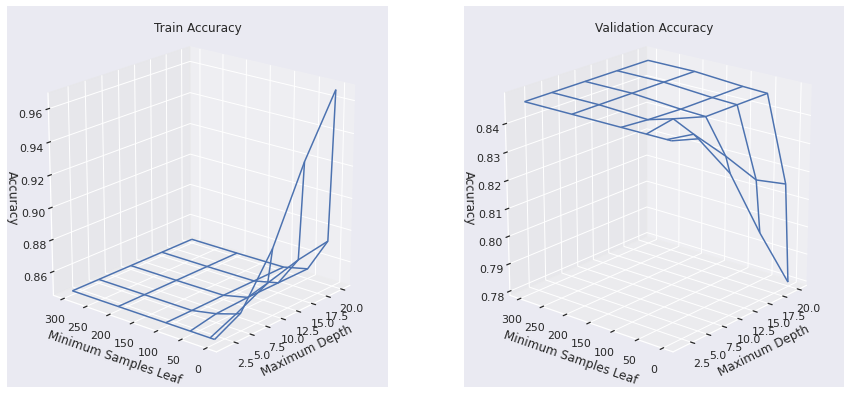

In [26]:
def plot_scores(ax, title, search, hyperparameters, score_key):
    # Get results from GridSearch and turn scores into matrix
    cv_results = search.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape((len(hyperparameters['max_depth']), len(hyperparameters['min_samples_leaf'])))
    max_depths = cv_results['param_max_depth'].reshape(scores.shape).data.astype(int)
    min_samples_leafs = cv_results['param_min_samples_leaf'].reshape(scores.shape).data.astype(int)
    
    # Plot result
    ax.plot_wireframe(max_depths, min_samples_leafs, scores)
    ax.view_init(20, 220)
    ax.set_xlabel('Maximum Depth')
    ax.set_ylabel('Minimum Samples Leaf')
    ax.set_zlabel('Accuracy')
    ax.set_title(title)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
plot_scores(ax1, 'Train Accuracy', search, hyperparameters, 'mean_train_score')
plot_scores(ax2, 'Validation Accuracy', search, hyperparameters, 'mean_test_score')

There is no question for this part, but make sure you understand why we see the trends we do here. Make sure you can answer the following questions:
* Why does the train accuracy spike up in the left graph, but go downward on the right graph?
* Which graph should we look at to pick the model that will hopefully do best in the future?
* Why is the spike in training accuracy only for the point with `max_depth=20` and `min_samples_leaf=1`? Why isn't the training accuracy very high for the other settings of `min_samples_leaf` even when `max_depth=20`?

--- 
# **🔍 Q7) Random Forest**
In class, we talked about the random forest ensemble. To show us empirically that such a simple idea of adding multiple classifiers works in practice, in this section we are going to implement a type of random forest and analyze its performance. 

This is slightly different than most work you'll do in our course since we are asking you to implement the inner-workings of part of a model. You should write code to make the ensemble, but you can use `sklearn`'s decision tree model as the models in your ensemble; in other words you don't need to implement a decision tree from scratch! 

Below, we have written the starter code for a class called `RandomForest416` that has methods similar to most sklearn models. You only have to implement the `fit` method, all other parts are implemented for you. However, you should understand how the other code works to help you identify what you need to do.

The `fit` method should train each tree on a different random sample of the examples in the given dataset with $n$ examples. Each random sample should select examples uniformly at random (with replacement) to make a new, modified, dataset of $n$ examples for that tree. To do this, you will want to use `np.random.randint` (documentation [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html)) to generate a random sequence of indices, and then use the `iloc` property on the given `pandas` objects to select those rows. 


In [42]:
### edTest(test_q7_random_forest) ###

import scipy.stats 

class RandomForest416: 
    """
    This class implements the common sklearn model interface (has a fit and predict function).
    
    A random forest is a collection of decision trees that are trained on random subsets of the 
    dataset. When predicting the value for an example, takes a majority vote from the trees.
    """
    
    def __init__(self, num_trees, max_depth=None):
        """
        Constructs a RandomForest416 that uses the given numbner of trees, each with a 
        max depth of max_depth.
        """
        self._trees = [
            DecisionTreeClassifier(max_depth=max_depth, random_state=1) 
            for i in range(num_trees)
        ]
        
    def fit(self, X, y):
        """
        Takes an input dataset X and a series of targets y and trains the RandomForest416.
        
        Each tree will be trained on a random sample of the data that samples the examples
        uniformly at random (with replacement). Each random dataset will have the same number
        of examples as the original dataset, but some examples may be missing or appear more 
        than once due to the random sampling with replacement.
        """    
        # TODO implement this method!

        for tree in self._trees:
          rand = np.random.randint(0, len(X), size=len(X))
          sample_train_X = X.iloc[rand]
          sample_train_y = y.iloc[rand]

          tree.fit(sample_train_X, sample_train_y)
        
            
    def predict(self, X):
        """
        Takes an input dataset X and returns the predictions for each example in X.
        """
        # Builds up a 2d array with n rows and T columns
        # where n is the number of points to classify and T is the number of trees
        predictions = np.zeros((len(X), len(self._trees)))
        for i, tree in enumerate(self._trees):
            # Make predictions using the current tree
            preds = tree.predict(X)
            
            # Store those predictions in ith column of the 2d array
            predictions[:, i] = preds
            
        # For each row of predictions, find the most frequent label (axis=1 means across columns)
        return scipy.stats.mode(predictions, axis=1)[0]

You can test out your implemenation by running the following cell:

In [44]:
rf = RandomForest416(2, max_depth=1)
rf.fit(train_data[features], train_data[target])
rf.predict(validation_data[features])

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

We can then compare how `sklearn`'s `DecisionTreeClassifier` to our `RandomForest416` to see how its training and validation accuracies compare as a function of the depth of the trees. The code below trains each model with a different max depth and then plots their accuracies. It might take some time to run, but it also prints the progress by showing the current depth it is on (it will range from 1 to 25).

Depth 1
Depth 3
Depth 5
Depth 7
Depth 9
Depth 11
Depth 13
Depth 15
Depth 17
Depth 19
Depth 21
Depth 23
Depth 25


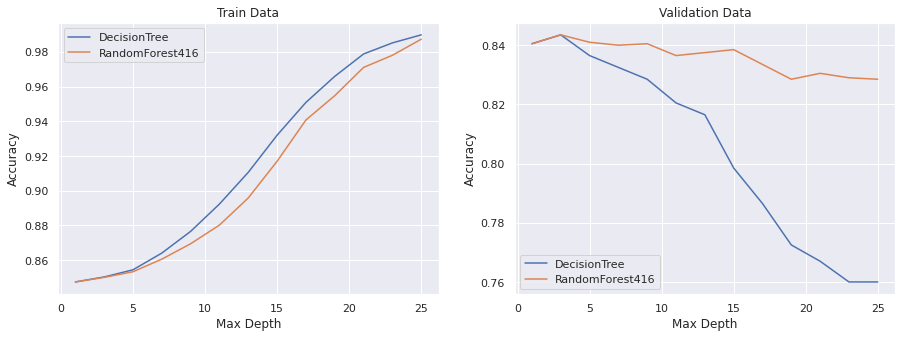

In [45]:
# First calculate the accuracies for each depth
depths = list(range(1, 26, 2))
dt_accuracies = []
rf_accuracies = []

for i in depths:
    print(f'Depth {i}')

    # Train and evaluate a Decision Tree Classifier with given max_depth
    tree = DecisionTreeClassifier(max_depth=i)
    tree.fit(train_data[features], train_data[target])
    dt_accuracies.append((
        accuracy_score(tree.predict(train_data[features]), train_data[target]),
        accuracy_score(tree.predict(validation_data[features]), validation_data[target])
    ))
    
    # Train and evaluate our RandomForest classifier with given max_depth 
    rf = RandomForest416(15, max_depth=i)
    rf.fit(train_data[features], train_data[target])
    rf_accuracies.append((     
        accuracy_score(rf.predict(train_data[features]), train_data[target]),
        accuracy_score(rf.predict(validation_data[features]), validation_data[target])
    ))
    
# Then plot the scores
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot training accuracies
axs[0].plot(depths, [acc[0] for acc in dt_accuracies], label='DecisionTree')
axs[0].plot(depths, [acc[0] for acc in rf_accuracies], label='RandomForest416')

# Plot validation accuracies
axs[1].plot(depths, [acc[1] for acc in dt_accuracies], label='DecisionTree')
axs[1].plot(depths, [acc[1] for acc in rf_accuracies], label='RandomForest416')

# Customize plots
axs[0].set_title('Train Data')
axs[1].set_title('Validation Data')
for ax in axs:
    ax.legend()
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('Accuracy')

### **🔍 Q8) Which model?**
Which model, when using max depth of 25, would we expect to perform the best in the future?

Save your answer in a variable called `q8`. So either write
* `q8 = 'DecisionTreeClassifier'`
* `q8 = 'RandomForest416'`


In [46]:
### edTest(test_q8) ###

# TODO select which model
q8 = 'RandomForest416'